In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostRegressor, Pool
from google.cloud import storage
import os
from io import StringIO, BytesIO
from itertools import islice

In [84]:
client = storage.Client()
bucket = client.get_bucket('price-estimation')

In [85]:
blobs = list(bucket.list_blobs(prefix='data/results'))

In [86]:
list(blobs)

[<Blob: price-estimation, data/results/, 1741775413689970>,
 <Blob: price-estimation, data/results/results_all_extras.csv, 1741928390973813>,
 <Blob: price-estimation, data/results/results_drop_extras_and_options.csv, 1741913474783711>,
 <Blob: price-estimation, data/results/results_drop_low_importance.csv, 1741922366361443>,
 <Blob: price-estimation, data/results/results_drop_unpractical.csv, 1742039602086701>,
 <Blob: price-estimation, data/results/results_impute_missing_values.csv, 1742035326630481>,
 <Blob: price-estimation, data/results/results_options.csv, 1741933006996110>,
 <Blob: price-estimation, data/results/results_remove_outliers.csv, 1741910680938105>]

In [56]:
res_dfs = []
for blob in blobs[1:]:
    print(blob.name)
    df_byte = blob.download_as_bytes()
    df = pd.read_csv(BytesIO(df_byte), index_col=0)
    res_dfs.append(df)

data/results/results_all_extras.csv
data/results/results_drop_extras_and_options.csv
data/results/results_drop_low_importance.csv
data/results/results_drop_unpractical.csv
data/results/results_impute_missing_values.csv
data/results/results_options.csv
data/results/results_remove_outliers.csv


In [59]:
list(bucket.list_blobs(prefix='data'))

[<Blob: price-estimation, data/, 1741613897529416>,
 <Blob: price-estimation, data/car_dictionary.pkl, 1741720678485579>,
 <Blob: price-estimation, data/results/, 1741775413689970>,
 <Blob: price-estimation, data/results/results_all_extras.csv, 1741928390973813>,
 <Blob: price-estimation, data/results/results_drop_extras_and_options.csv, 1741913474783711>,
 <Blob: price-estimation, data/results/results_drop_low_importance.csv, 1741922366361443>,
 <Blob: price-estimation, data/results/results_drop_unpractical.csv, 1742039602086701>,
 <Blob: price-estimation, data/results/results_impute_missing_values.csv, 1742035326630481>,
 <Blob: price-estimation, data/results/results_options.csv, 1741933006996110>,
 <Blob: price-estimation, data/results/results_remove_outliers.csv, 1741910680938105>,
 <Blob: price-estimation, data/train_test_sets/, 1741775431478002>,
 <Blob: price-estimation, data/train_test_sets/processed_test_set_ALL_EXTRAS.csv, 1742135751874949>,
 <Blob: price-estimation, data/tra

In [105]:
def load_test_sets():
    client = storage.Client()
    bucket = client.get_bucket('price-estimation')
    blob_test = bucket.get_blob('data/train_test_sets/test_02032024.csv')
    blob_test_processed = bucket.get_blob('data/train_test_sets/processed_test_set_DROP_UNPRACTICAL.csv.csv')
    test_bytes = blob_test.download_as_bytes()
    test_processed_bytes = blob_test_processed.download_as_bytes()
    test = pd.read_csv(BytesIO(test_bytes), index_col=0)
    processed_test = pd.read_csv(BytesIO(test_processed_bytes), index_col=0)
    return test, processed_test

In [81]:
def load_model(name):
    client = storage.Client()
    bucket = client.get_bucket('price-estimation')
    blob_cb = bucket.get_blob(f'models/{name}.cbm')
    cb_name = f"{name}.cbm"
    blob_cb.download_to_filename(cb_name)
    cb = CatBoostRegressor().load_model(cb_name)
    return cb

In [128]:
test, test_processed = load_test_sets()

In [74]:
res_df = pd.concat(res_dfs, axis=1)

In [87]:
cb = load_model('catboost_drop_unpractical')
cb2 = load_model('catboost_q2')

In [151]:
cb2.feature_names_

['lat',
 'lon',
 'is_new',
 'mileage',
 'crashed',
 'engine_size',
 'registration_year',
 'engine_power',
 'fuel_type',
 'gearbox_type',
 'brand',
 'model',
 'extra_turbo',
 'extra_steering_lights',
 'extra_collision_avoidance_system',
 'extra_trip_computer',
 'extra_wheelchair',
 'extra_apple_carplay',
 'extra_leather_seats',
 'extra_anti_theft_system_gps',
 'extra_rain_sensor',
 'extra_panoramic_roof',
 'extra_dvd',
 'extra_automatic_parking',
 'extra_multi_purpose_steering_wheel',
 'extra_tcs_asr',
 'extra_tv_camera',
 'extra_power_windows',
 'extra_bucket_seats',
 'extra_hitch',
 'extra_aircondition(a_c)',
 'extra_heated_seats',
 'extra_power_seats',
 'extra_alumium_rims',
 'extra_locking_differential',
 'extra_android_auto',
 'extra_roof_rails',
 'extra_armored',
 'extra_lane_assist',
 'never_crashed',
 'extra_immobilizer',
 'extra_rear_view_camera',
 'extra_air_suspension',
 'extra_bluetooth',
 'extra_parktronic',
 'extra_isofix_children_seats',
 'extra_electric_sunroof',
 'extra

In [133]:
X_test_proc, y_test_proc = test_processed.drop(columns=['raw_price']), test_processed['raw_price']

In [134]:
X_test_proc.select_dtypes(include=['object', 'category', 'int', 'bool']).columns

Index(['is_new', 'crashed', 'fuel_type', 'gearbox_type', 'brand', 'model',
       'extra_turbo', 'extra_steering_lights',
       'extra_collision_avoidance_system', 'extra_trip_computer',
       'extra_wheelchair', 'extra_apple_carplay', 'extra_leather_seats',
       'extra_anti_theft_system_gps', 'extra_rain_sensor',
       'extra_panoramic_roof', 'extra_dvd', 'extra_automatic_parking',
       'extra_multi_purpose_steering_wheel', 'extra_tcs_asr',
       'extra_tv_camera', 'extra_power_windows', 'extra_bucket_seats',
       'extra_hitch', 'extra_aircondition(a_c)', 'extra_heated_seats',
       'extra_power_seats', 'extra_alumium_rims', 'extra_locking_differential',
       'extra_android_auto', 'extra_roof_rails', 'extra_armored',
       'extra_lane_assist', 'never_crashed', 'extra_immobilizer',
       'extra_rear_view_camera', 'extra_air_suspension', 'extra_bluetooth',
       'extra_parktronic', 'extra_isofix_children_seats',
       'extra_electric_sunroof', 'extra_abs', 'extra_teleph

In [135]:
categorical_features = [X_test_proc.columns.get_loc(x) for x in
                          X_test_proc.select_dtypes(include=['object', 'category', 'int', 'bool']).columns.tolist()]

In [136]:
X_test_proc.iloc[:,categorical_features] = X_test_proc.iloc[:,categorical_features].fillna("nan")

In [137]:
test_pool = Pool(data=X_test_proc, label=y_test_proc, cat_features=categorical_features)

In [143]:
res_df = pd.concat([test, res_df], axis=1)

In [144]:
res_df

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,...,abs_residuals_impute_missing_values,ape_impute_missing_values,id,residuals_options,abs_residuals_options,ape_options,id,residuals_remove_outliers,abs_residuals_remove_outliers,ape_remove_outliers
97871,37.967795,23.617791,fa2bb5bc-4344-45e4-bedd-f3b6ac023708,False,NaN,Audi A4 '22 S Line 40 TDI Hybrid S tronic 2.0 ...,"{'count': 35, 'urls': ['https://static.car.gr/...",343992280,True,3026721,...,5092.969667,0.159255,343992280,-7861.407404,7861.407404,0.245823,343992280,-5778.789636,5778.789636,0.180700
46170,39.561824,21.717647,a7a108e9-5da9-4209-802e-11d1b6864f7b,False,NaN,Skoda Octavia '04 RS TURBO 180 HP,"{'count': 5, 'urls': ['https://static.car.gr/4...",43582010,True,876905,...,1209.163671,0.326801,43582010,-1157.852686,1157.852686,0.312933,43582010,-1144.038789,1144.038789,0.309200
87214,40.699982,22.930698,076e678b-5aa3-40e4-89b7-7ace7fd5ff45,False,NaN,Hyundai i 20 '12,"{'count': 32, 'urls': ['https://static.car.gr/...",339418109,True,1010298,...,311.657611,0.043286,339418109,306.497059,306.497059,0.042569,339418109,82.248465,82.248465,0.011423
86119,37.881689,23.752999,3e2e94d5-e727-430f-96ae-33fb5b5cdded,False,NaN,"Bmw X6 M '16 AKRAPOVIC,B&O,HUD,SUNROOF,N.VISION","{'count': 84, 'urls': ['https://static.car.gr/...",338800209,False,1000399,...,1626.059788,0.018270,338800209,-1302.734451,1302.734451,0.014637,338800209,-8874.983511,8874.983511,0.099719
67363,40.591626,22.726574,b0b56081-0cf1-4203-9f86-ad94692d6819,False,NaN,Kia Picanto '05,"{'count': 10, 'urls': ['https://static.car.gr/...",44290997,True,1001510490,...,508.333796,0.141204,44290997,681.472394,681.472394,0.189298,44290997,557.590971,557.590971,0.154886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4560,40.269484,23.306947,1057afab-a353-45b2-9f18-0e9d1c6e55b0,False,NaN,Volkswagen Scirocco '10 Look R,"{'count': 13, 'urls': ['https://static.car.gr/...",41458505,True,10171708,...,167.209644,0.013934,41458505,150.687937,150.687937,0.012557,41458505,-129.708784,129.708784,0.010809
42214,38.736460,21.426493,5ba02aa7-1e18-4d0c-b6a6-e2964857b84c,False,NaN,Bmw 320 '05 E46 SEDAN,"{'count': 7, 'urls': ['https://static.car.gr/4...",43413216,False,1001403054,...,887.353670,0.126765,43413216,85.254055,85.254055,0.012179,43413216,-238.296144,238.296144,0.034042
57329,41.048163,23.524707,c418e538-6e73-42f6-8be6-45fc5dbbb8c6,False,NaN,"Peugeot 307 '06 CC CABRIO 1,6 FULL EXTRA","{'count': 18, 'urls': ['https://static.car.gr/...",43948506,True,1001475410,...,1665.642458,0.277607,43948506,1670.145446,1670.145446,0.278358,43948506,1718.243477,1718.243477,0.286374
42100,37.071222,22.217558,0ee12d32-2ede-47f7-a688-d5ac321e3b5b,False,NaN,Bmw Z4 '06 Roadster smg,"{'count': 7, 'urls': ['https://static.car.gr/4...",43411506,True,1001401787,...,2652.681600,0.294742,43411506,-1716.146451,1716.146451,0.190683,43411506,-495.680521,495.680521,0.055076


In [146]:
res_df['pred_all_extras'] = res_df.raw_price - res_df.residuals_all_extras
res_df['pred_options'] = res_df.raw_price - res_df.residuals_options
res_df['pred_outliers'] = res_df.raw_price - res_df.residuals_remove_outliers
res_df['pred_drop_all'] = res_df.raw_price - res_df.residuals_drop_extras_and_options
res_df['pred_unpractical'] = res_df.raw_price - res_df.residuals_drop_unpractical
res_df['pred_low_importance'] = res_df.raw_price - res_df.residuals_drop_low_importance
res_df['pred_impute_missing'] = res_df.raw_price - res_df.residuals_drop_low_importance

In [149]:
res_df['pe_all_extras'] = res_df.residuals_all_extras/res_df.raw_price
res_df['pe_options'] = res_df.residuals_options/res_df.raw_price
res_df['pe_outliers'] = res_df.residuals_remove_outliers/res_df.raw_price
res_df['pe_drop_all'] = res_df.residuals_drop_extras_and_options/res_df.raw_price
res_df['pe_unpractical'] = res_df.residuals_drop_unpractical/res_df.raw_price
res_df['pe_low_importance'] = res_df.residuals_drop_low_importance/res_df.raw_price
res_df['pe_impute_missing'] = res_df.residuals_impute_missing_values/res_df.raw_price

In [150]:
qs = [0.01, 0.05,0.25,0.5,0.75,0.9, 0.95, 0.99]

In [33]:
ape_cols = [x for x in res_df.columns if 'ape' in x]
abs_res = [x for x in res_df.columns if 'abs' in x]
residuals_cols = [x for x in res_df.columns.drop(abs_res) if 'residuals' in x]

In [ ]:
pd.concat([res_df[ape_cols]].mean(),res_df[ape_cols].median(), res_df[abs_res].mean(), res_df.)

In [28]:
print(res_df[[x for x in res_df.columns if 'ape' in x]].mean().to_markdown().rename(columns={'0':'MAPE'}))

|                             |        0 |
|:----------------------------|---------:|
| ape_all_extras              | 0.146884 |
| ape_drop_extras_and_options | 0.149857 |
| ape_drop_low_importance     | 0.147278 |
| ape_drop_unpractical        | 0.1477   |
| ape_impute_missing_values   | 0.147684 |
| ape_options                 | 0.147313 |
| ape_remove_outliers         | 0.153436 |


In [39]:
print(res_df[[x for x in res_df.columns if 'ape' in x]].describe(qs).to_markdown())

|       |   ape_all_extras |   ape_drop_extras_and_options |   ape_drop_low_importance |   ape_drop_unpractical |   ape_impute_missing_values |    ape_options |   ape_remove_outliers |
|:------|-----------------:|------------------------------:|--------------------------:|-----------------------:|----------------------------:|---------------:|----------------------:|
| count |   20286          |               20286           |            20286          |        20286           |             20286           | 20286          |       20286           |
| mean  |       0.146884   |                   0.149857    |                0.147278   |            0.1477      |                 0.147684    |     0.147313   |           0.153436    |
| std   |       0.43854    |                   0.452887    |                0.444773   |            0.435953    |                 0.457689    |     0.425355   |           0.449531    |
| min   |       4.6572e-06 |                   2.46947e-07 |               

In [17]:
results = pd.concat([results_extras, results_options, results_outliers, results_drop_all,results_unpractical, results_low_importance],axis=1)

In [50]:
train, test = load_train_test()

In [51]:
train.dtypes

lat                                 float64
lon                                 float64
uuid                                 object
is_new                                 bool
label                                object
                                     ...   
safety_driver_assistance_options    float64
performance_handling_options        float64
utility_options                     float64
premium_options                     float64
infotainment_options                float64
Length: 119, dtype: object

In [41]:
cb = load_model()

In [43]:
cb.feature_names_

['lat',
 'lon',
 'is_new',
 'mileage',
 'crashed',
 'engine_size',
 'registration_year',
 'engine_power',
 'fuel_type',
 'gearbox_type',
 'brand',
 'model',
 'extra_turbo',
 'extra_steering_lights',
 'extra_collision_avoidance_system',
 'extra_trip_computer',
 'extra_wheelchair',
 'extra_apple_carplay',
 'extra_leather_seats',
 'extra_anti_theft_system_gps',
 'extra_rain_sensor',
 'extra_panoramic_roof',
 'extra_dvd',
 'extra_automatic_parking',
 'extra_multi_purpose_steering_wheel',
 'extra_tcs_asr',
 'extra_tv_camera',
 'extra_power_windows',
 'extra_bucket_seats',
 'extra_hitch',
 'extra_aircondition(a_c)',
 'extra_heated_seats',
 'extra_power_seats',
 'extra_alumium_rims',
 'extra_locking_differential',
 'extra_android_auto',
 'extra_roof_rails',
 'extra_armored',
 'extra_lane_assist',
 'never_crashed',
 'extra_immobilizer',
 'extra_rear_view_camera',
 'extra_air_suspension',
 'extra_bluetooth',
 'extra_parktronic',
 'extra_isofix_children_seats',
 'extra_electric_sunroof',
 'extra

In [21]:
qs = [0.01, 0.05, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

In [44]:
zoom = {'is_new': 1,
 'mileage':-1,
 'crashed':-1,
 'engine_size':1,
 'engine_power':1,
  'rim_size':1}

In [50]:
zoom.update({x:1 for x in cb.feature_names_ if 'extra' in x})

In [51]:
zoom

{'is_new': 1,
 'mileage': -1,
 'crashed': -1,
 'engine_size': 1,
 'engine_power': 1,
 'rim_size': 1,
 'extra_turbo': 1,
 'extra_steering_lights': 1,
 'extra_collision_avoidance_system': 1,
 'extra_trip_computer': 1,
 'extra_wheelchair': 1,
 'extra_apple_carplay': 1,
 'extra_leather_seats': 1,
 'extra_anti_theft_system_gps': 1,
 'extra_rain_sensor': 1,
 'extra_panoramic_roof': 1,
 'extra_dvd': 1,
 'extra_automatic_parking': 1,
 'extra_multi_purpose_steering_wheel': 1,
 'extra_tcs_asr': 1,
 'extra_tv_camera': 1,
 'extra_power_windows': 1,
 'extra_bucket_seats': 1,
 'extra_hitch': 1,
 'extra_aircondition(a_c)': 1,
 'extra_heated_seats': 1,
 'extra_power_seats': 1,
 'extra_alumium_rims': 1,
 'extra_locking_differential': 1,
 'extra_android_auto': 1,
 'extra_roof_rails': 1,
 'extra_armored': 1,
 'extra_lane_assist': 1,
 'extra_immobilizer': 1,
 'extra_rear_view_camera': 1,
 'extra_air_suspension': 1,
 'extra_bluetooth': 1,
 'extra_parktronic': 1,
 'extra_isofix_children_seats': 1,
 'extra_e

In [23]:
results.loc[:,[x for x in results.columns if 'ape' in x]].describe(qs)

,ape_all_extras,ape_options,ape_remove_outliers,ape_drop_extras_and_options,ape_drop_unpractical,ape_drop_low_importance
count,20286.000000,20286.000000,20286.000000,2.028600e+04,20286.000000,20286.000000
mean,0.146884,0.147313,0.153436,1.498568e-01,0.154847,0.147278
std,0.438540,0.425355,0.449531,4.528868e-01,0.453346,0.444773
min,0.000005,0.000010,0.000024,2.469466e-07,0.000014,0.000002
1%,0.001307,0.001327,0.001339,1.447999e-03,0.001587,0.001360
5%,0.006838,0.007176,0.007016,7.456734e-03,0.008207,0.006935
25%,0.038060,0.038316,0.038648,3.940140e-02,0.040705,0.038312
50%,0.087313,0.087881,0.088659,8.883838e-02,0.093280,0.087601
75%,0.170046,0.171736,0.174760,1.725607e-01,0.180467,0.171429
90%,0.301630,0.297944,0.313455,3.020458e-01,0.314255,0.300246


In [3]:
train, test = load_train_test()


In [26]:
results.head()

,id,residuals_all_extras,abs_residuals_all_extras,ape_all_extras,id,residuals_options,abs_residuals_options,ape_options,id,residuals_remove_outliers,...,abs_residuals_drop_extras_and_options,ape_drop_extras_and_options,id,residuals_drop_unpractical,abs_residuals_drop_unpractical,ape_drop_unpractical,id,residuals_drop_low_importance,abs_residuals_drop_low_importance,ape_drop_low_importance
97871,343992280,-6303.354826,6303.354826,0.197103,343992280,-7861.407404,7861.407404,0.245823,343992280,-5778.789636,...,7191.108696,0.224863,343992280,-2355.328576,2355.328576,0.073650,343992280,-6374.279688,6374.279688,0.199321
46170,43582010,-1162.602634,1162.602634,0.314217,43582010,-1157.852686,1157.852686,0.312933,43582010,-1144.038789,...,1278.600542,0.345568,43582010,-470.688594,470.688594,0.127213,43582010,-972.012328,972.012328,0.262706
87214,339418109,117.232165,117.232165,0.016282,339418109,306.497059,306.497059,0.042569,339418109,82.248465,...,87.350862,0.012132,339418109,127.174110,127.174110,0.017663,339418109,383.291580,383.291580,0.053235
86119,338800209,-3405.899315,3405.899315,0.038269,338800209,-1302.734451,1302.734451,0.014637,338800209,-8874.983511,...,714.259666,0.008025,338800209,478.202132,478.202132,0.005373,338800209,2545.173990,2545.173990,0.028597
67363,44290997,717.897308,717.897308,0.199416,44290997,681.472394,681.472394,0.189298,44290997,557.590971,...,697.544267,0.193762,44290997,333.679187,333.679187,0.092689,44290997,533.768962,533.768962,0.148269


In [29]:
res = pd.concat([test, results],axis=1)

In [32]:
res['pred_all_extras'] = res.raw_price - res.residuals_all_extras
res['pred_options'] = res.raw_price - res.residuals_options
res['pred_outliers'] = res.raw_price - res.residuals_remove_outliers
res['pred_drop_all'] = res.raw_price - res.residuals_drop_extras_and_options
res['pred_unpractical'] = res.raw_price - res.residuals_drop_unpractical
res['pred_low_importance'] = res.raw_price - res.residuals_drop_low_importance

In [34]:
res['pe_all_extras'] = res.residuals_all_extras/res.raw_price
res['pe_options'] = res.residuals_options/res.raw_price
res['pe_outliers'] = res.residuals_remove_outliers/res.raw_price
res['pe_drop_all'] = res.residuals_drop_extras_and_options/res.raw_price
res['pe_unpractical'] = res.residuals_drop_unpractical/res.raw_price
res['pe_low_importance'] = res.residuals_drop_low_importance/res.raw_price

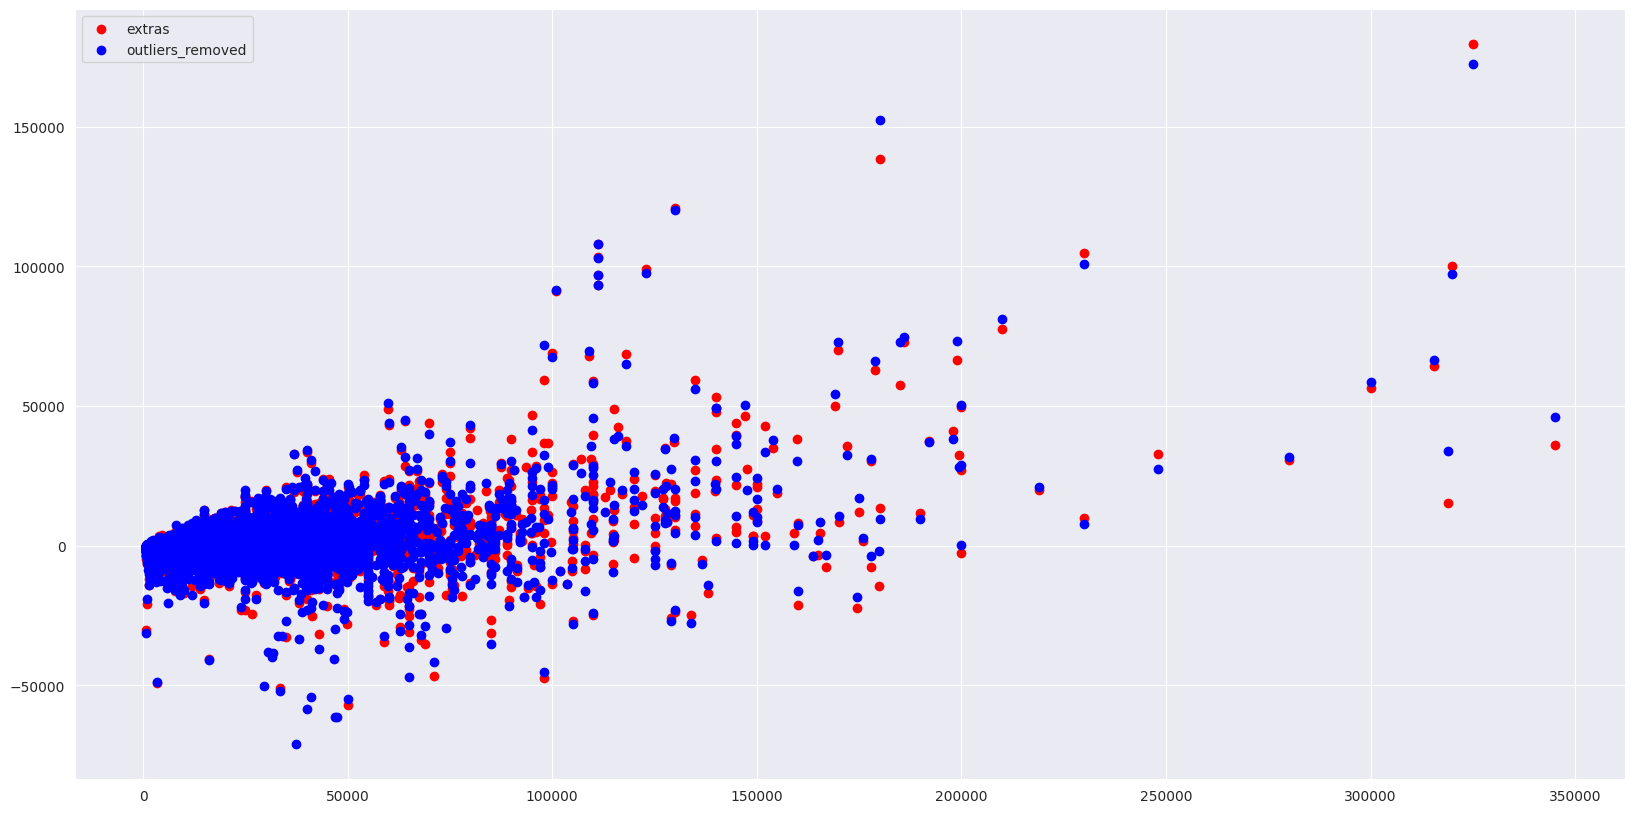

In [36]:
plt.figure(figsize=(20,10))
plt.scatter(res['raw_price'], res['residuals_all_extras'], color='red', label='extras' )
plt.scatter(res['raw_price'], res['residuals_remove_outliers'], color='blue', label='outliers_removed' )
plt.legend()


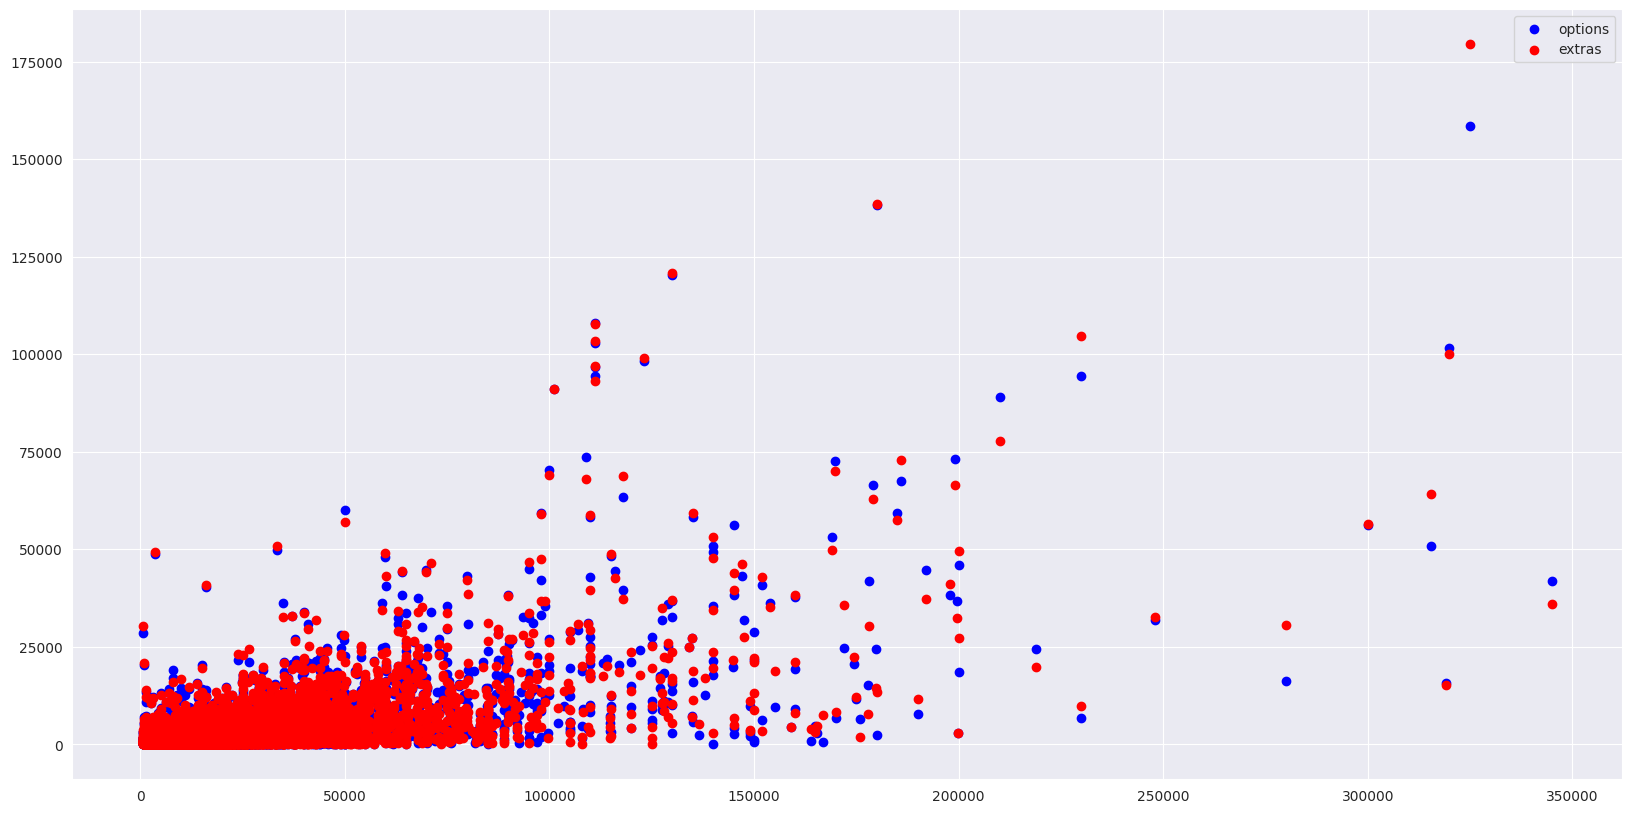

In [37]:
plt.figure(figsize=(20,10))
plt.scatter(res['raw_price'], res['abs_residuals_options'], color='blue', label='options' )
plt.scatter(res['raw_price'], res['abs_residuals_all_extras'], color='red', label='extras' )
plt.legend()


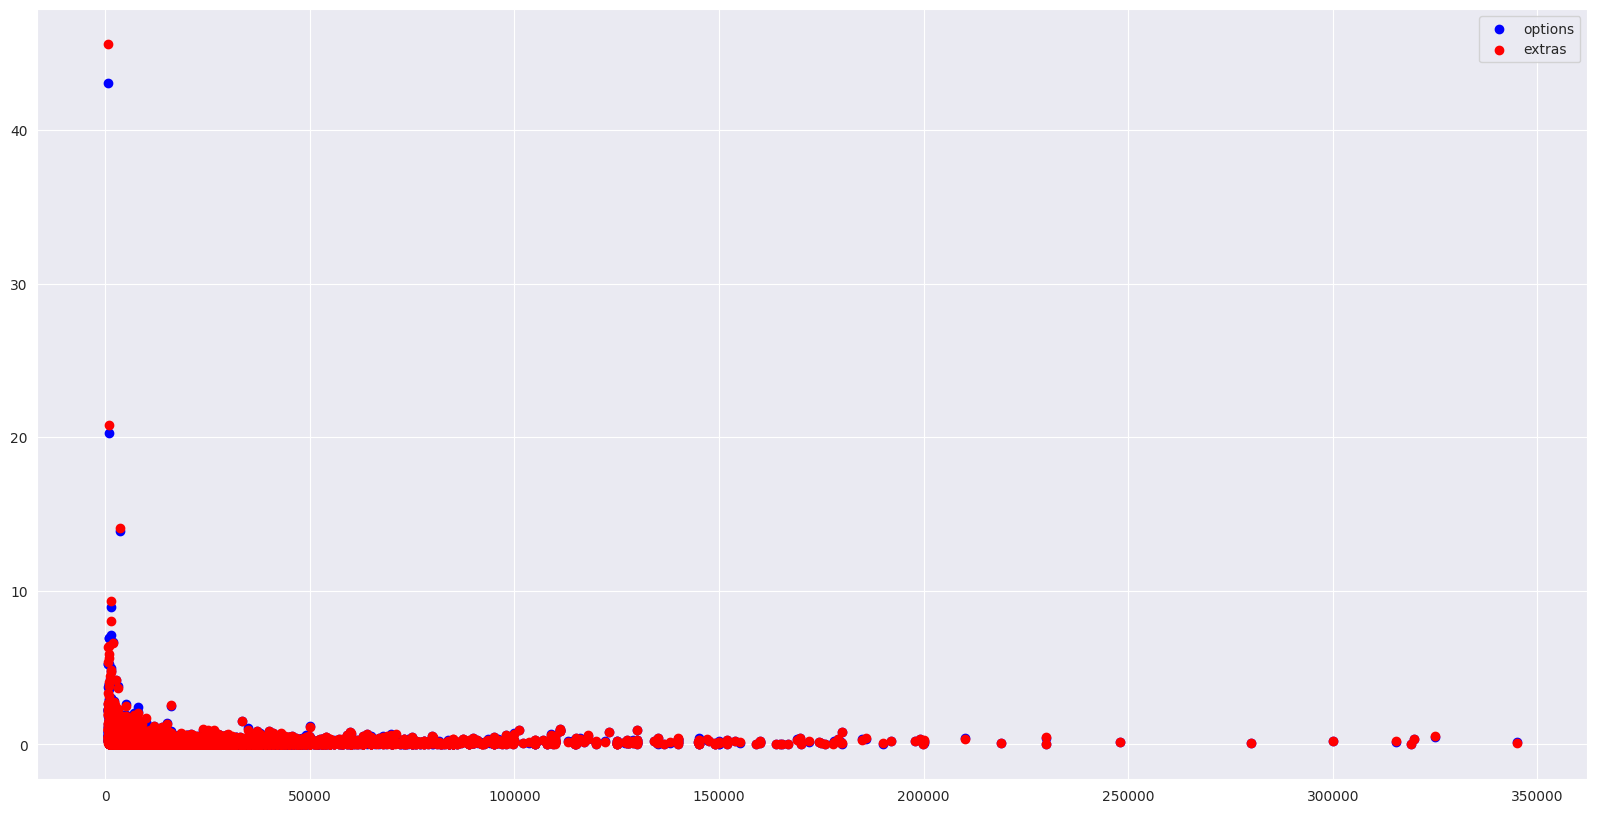

In [38]:
plt.figure(figsize=(20,10))
plt.scatter(res['raw_price'], res['ape_options'], color='blue', label='options' )
plt.scatter(res['raw_price'], res['ape_all_extras'], color='red', label='extras' )
plt.legend()


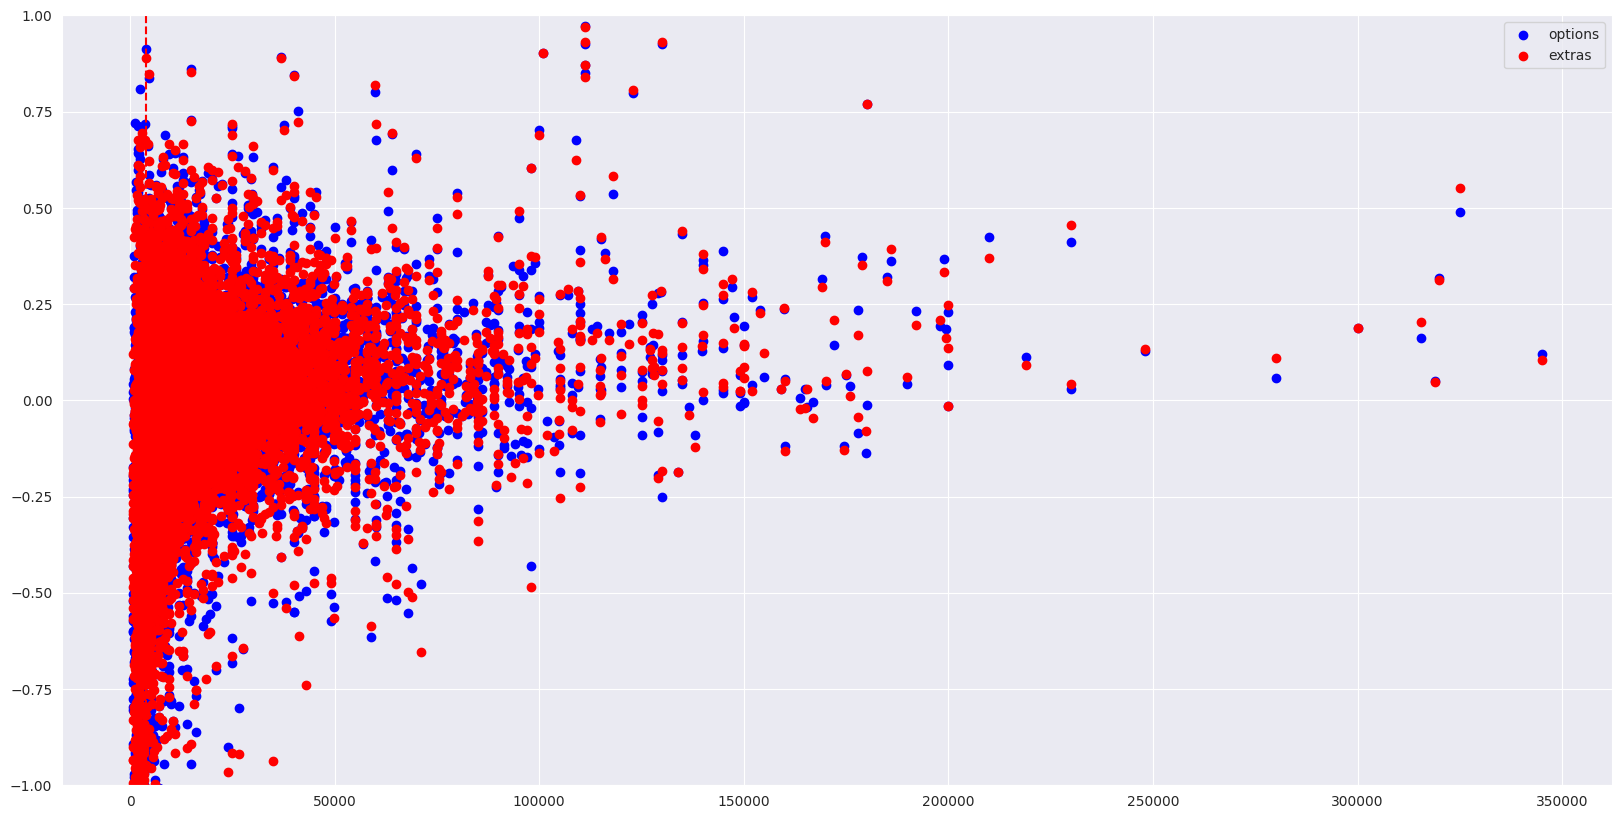

In [53]:
plt.figure(figsize=(20,10))
plt.scatter(res['raw_price'], res['pe_options'], color='blue', label='options' )
plt.scatter(res['raw_price'], res['pe_all_extras'], color='red', label='extras' )
plt.ylim([-1, 1])
plt.axvline(4000, linestyle='--', color='red')
plt.legend()


In [40]:
# We observe very high overestimation errors for prices close to zero. These points are outliers which are

(-15000.0, 15000.0)

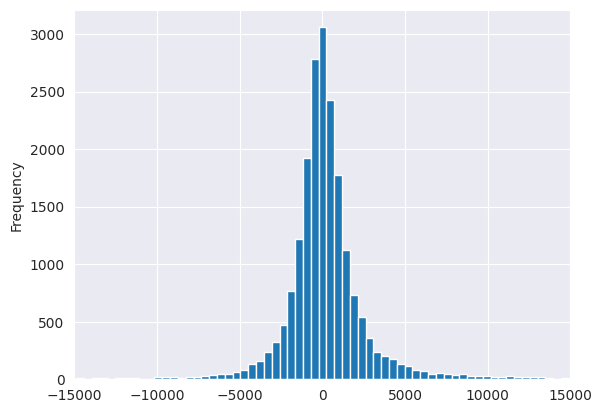

In [41]:
res.residuals_all_extras.plot(kind='hist', bins=500)
plt.xlim([-15000,15000])

In [42]:
from sklearn.metrics import r2_score

In [43]:
1 - (1 - r2_score(res.raw_price, res.pred_all_extras))*(test.shape[0]-1)/(test.shape[0]- test.shape[1])

0.9193881139186794

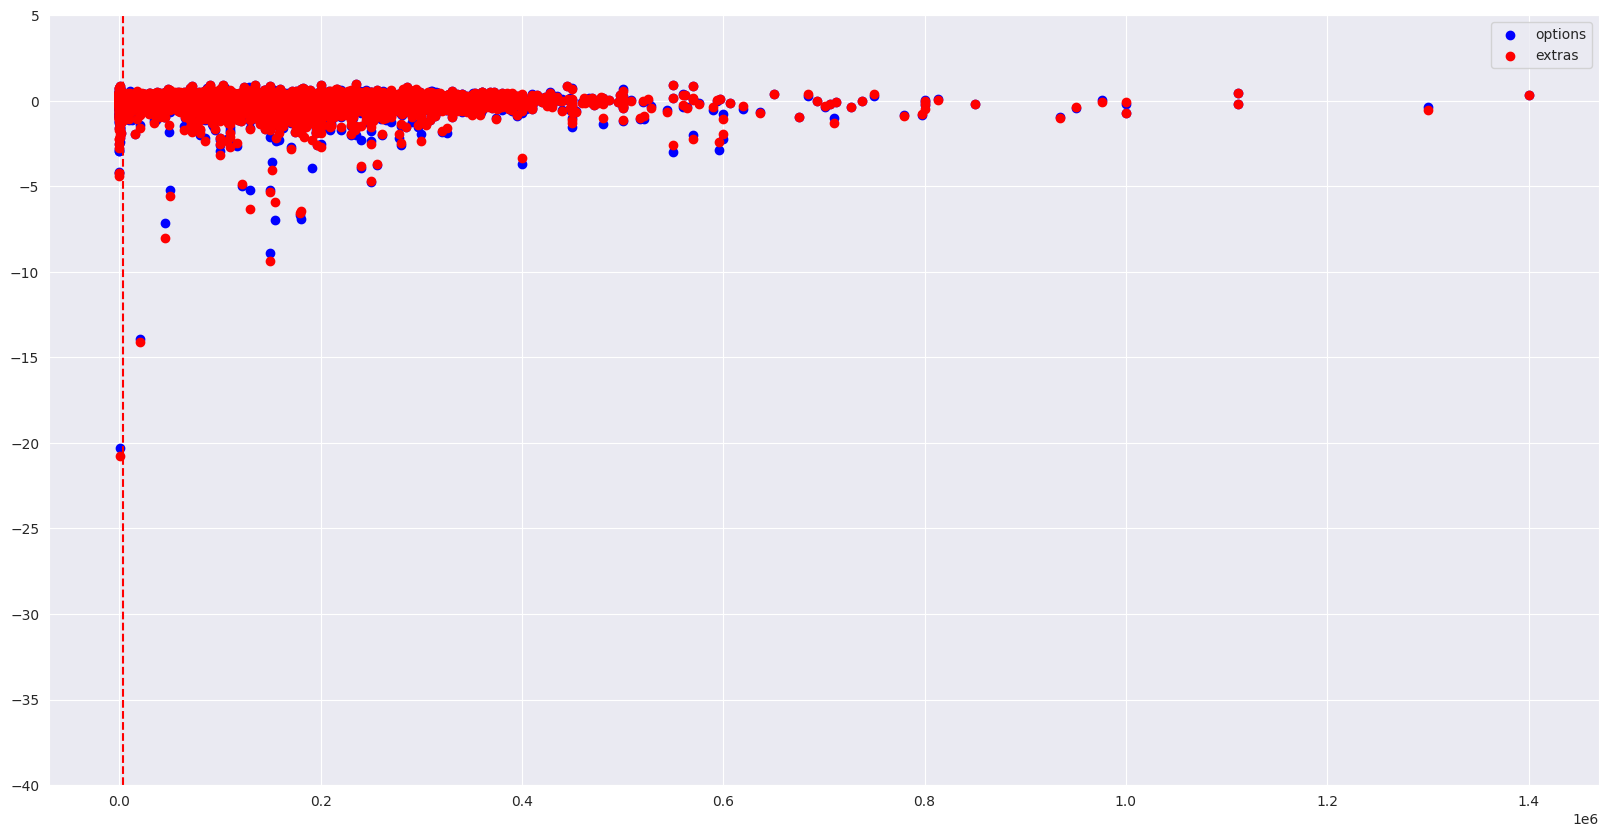

In [44]:
plt.figure(figsize=(20,10))
plt.scatter(res['mileage'], res['pe_options'], color='blue', label='options' )
plt.scatter(res['mileage'], res['pe_all_extras'], color='red', label='extras' )
plt.ylim([-40, 5])
plt.axvline(4000, linestyle='--', color='red')
plt.legend()


In [63]:
# again we see a problem regarding cars with very low mileage (under 4000). These points are again outliers

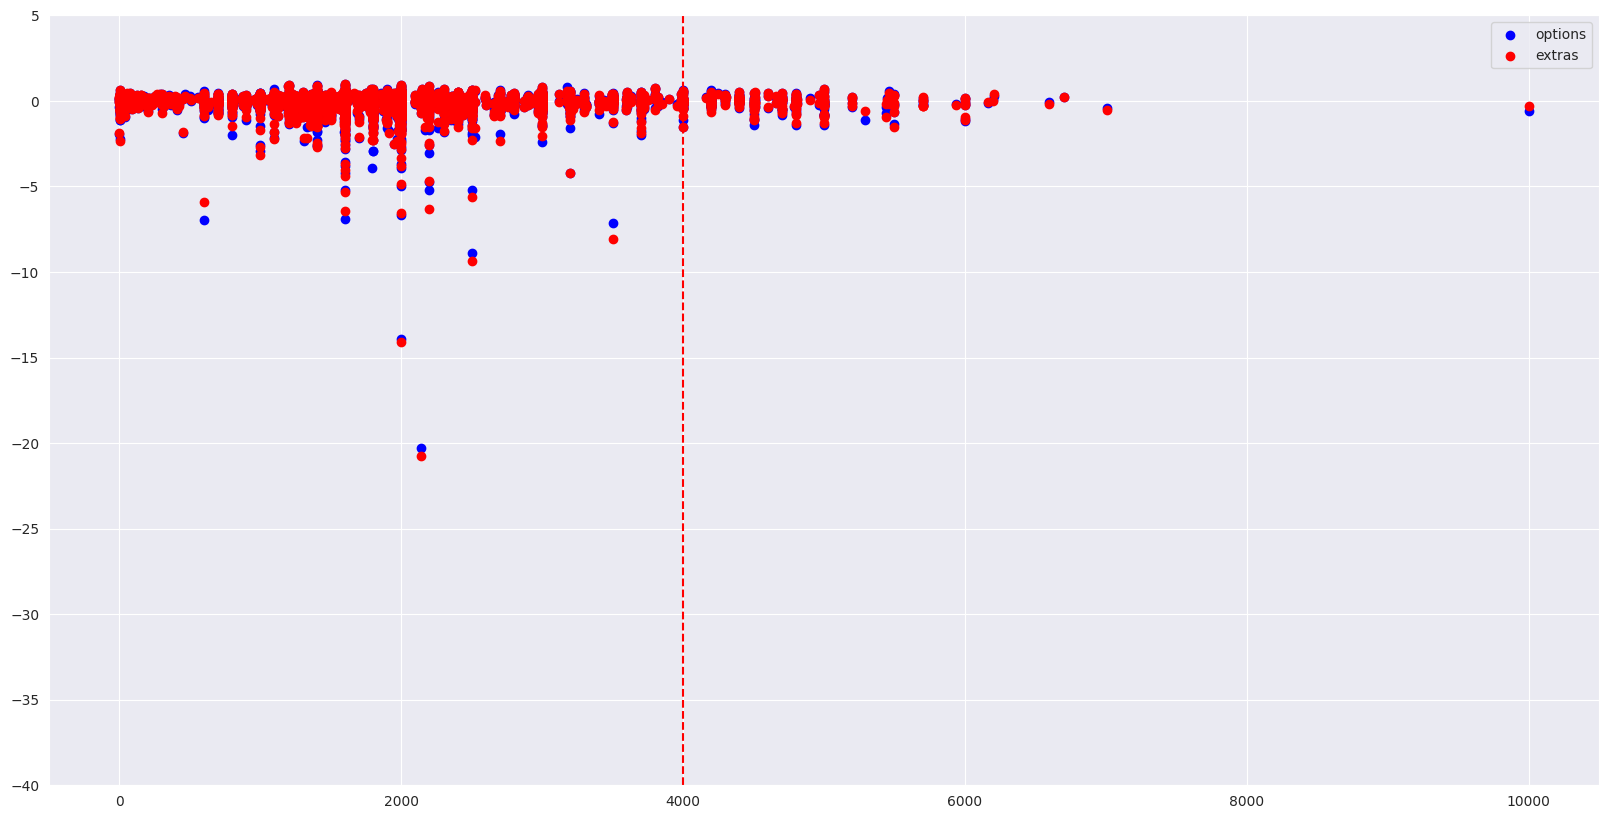

In [45]:
plt.figure(figsize=(20,10))
plt.scatter(res['engine_size'], res['pe_options'], color='blue', label='options' )
plt.scatter(res['engine_size'], res['pe_all_extras'], color='red', label='extras' )
plt.ylim([-40, 5])
plt.axvline(4000, linestyle='--', color='red')
plt.legend()


In [65]:
# here we notice some engine sizes with value 0 which we should have cleaned but realised late.

In [54]:
zoom = pd.read_csv('../data/car_ads_chunk1.csv')

In [55]:
zoom.head()

,Unnamed: 0,geolocation,marketplace,leasing,price_per_unit,consent,is_new,foreign_number_plate,states,label,...,dealers_only,modified,all_final_category_ids,length,has_360photos,vtype_xyma_or_part,promotion,fueltype,has_photos,parked
0,fe2d1856-9561-4383-b721-2b20b41b7b54,"{'geolocation': {'lat': 37.923983, 'lon': 23.7...",NaN,"{'only_leasing': False, 'default_leasing_optio...",NaN,NaN,False,False,"{'is_non_public': False, 'is_deleted': False, ...",NaN,...,False,2025-02-14 12:14:14,[15218],NaN,False,car,"{'available': True, 'previous_promotions_count...",Petrol,True,-
1,5693a462-24ed-4c04-ab86-13f4fbefdebf,"{'geolocation': {'lat': 37.99018681814817, 'lo...",NaN,"{'only_leasing': False, 'default_leasing_optio...",NaN,NaN,False,False,"{'is_non_public': False, 'is_deleted': False, ...",NaN,...,False,2025-02-14 12:14:01,[15218],NaN,False,car,"{'available': True, 'previous_promotions_count...",Plug-in hybrid petrol,True,-
2,d8adcb3d-f9b3-4f75-b59d-842b4ef3263a,"{'geolocation': {'lat': 37.9870202704, 'lon': ...",NaN,"{'only_leasing': False, 'default_leasing_optio...",NaN,NaN,False,False,"{'is_non_public': False, 'is_deleted': False, ...",NaN,...,False,2025-02-14 12:23:06,[15211],NaN,False,car,NaN,Petrol,True,-
3,db5b7b25-1f6a-467e-8df4-7b8390dd146f,"{'geolocation': {'lat': 40.5851712258, 'lon': ...",NaN,"{'only_leasing': False, 'default_leasing_optio...",NaN,NaN,False,False,"{'is_non_public': False, 'is_deleted': False, ...",NaN,...,False,2025-02-14 12:23:04,[15213],NaN,False,car,NaN,Plug-in hybrid diesel,True,-
4,ac99cd0b-2081-44c0-bbcb-5a9083b48c9f,"{'geolocation': {'lat': 37.9615741704, 'lon': ...",NaN,"{'only_leasing': False, 'default_leasing_optio...",NaN,NaN,False,False,"{'is_non_public': False, 'is_deleted': False, ...",NaN,...,False,2025-02-14 12:22:58,[15211],NaN,False,car,NaN,Petrol,True,-


In [58]:
res[res.ape_all_extras> res.ape_all_extras.quantile(.97)].describe()

,lat,lon,id,user_id,mileage,raw_price,engine_size,registration_month,registration_year,battery_range,...,pred_outliers,pred_drop_all,pred_unpractical,pred_low_importance,pe_all_extras,pe_options,pe_outliers,pe_drop_all,pe_unpractical,pe_low_importance
count,609.000000,609.000000,6.090000e+02,6.090000e+02,609.000000,609.000000,609.000000,609.000000,609.000000,5.000000,...,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000
mean,38.516750,23.376047,1.119242e+08,4.730305e+08,171216.050903,8892.170772,1948.390805,4.110016,2006.535304,172.000000,...,9283.467160,9271.888316,9229.744098,9202.182333,-1.023432,-1.016054,-1.057717,-1.033702,-1.006612,-1.003211
std,1.444029,1.160119,1.262083e+08,4.990262e+08,131853.086983,22468.765988,909.132880,3.668776,4.639201,183.630063,...,13255.757626,13708.860555,14020.328756,13507.658294,2.302732,2.219086,2.330648,2.383326,2.385142,2.344922
min,34.967405,19.772303,3.288983e+06,3.711800e+04,0.000000,600.000000,0.000000,1.000000,2001.000000,80.000000,...,654.977657,253.218133,288.770158,-96.510174,-45.583840,-43.087403,-47.002811,-47.797448,-48.038814,-47.281543
25%,37.946734,22.907454,4.253328e+07,1.005044e+06,92000.000000,1850.000000,1400.000000,1.000000,2004.000000,80.000000,...,3448.928386,3392.318803,3428.074733,3378.277238,-1.097263,-1.117803,-1.220700,-1.130849,-1.130769,-1.102533
50%,38.049531,23.678753,4.377099e+07,1.006956e+07,163000.000000,3000.000000,1800.000000,2.000000,2005.000000,100.000000,...,5577.912783,5441.921216,5475.477120,5491.393958,-0.778398,-0.765132,-0.771152,-0.789969,-0.760543,-0.765775
75%,39.557923,23.806629,4.439891e+07,1.001275e+09,225000.000000,6000.000000,2143.000000,7.000000,2008.000000,100.000000,...,9420.828436,9310.094586,9315.824025,9344.186882,-0.595900,-0.566905,-0.590644,-0.567422,-0.516106,-0.567175
max,41.510098,28.167520,3.448308e+08,1.001530e+09,999999.000000,325000.000000,6000.000000,12.000000,2025.000000,500.000000,...,152506.266155,182161.087690,156467.938290,163679.475759,0.970443,0.970914,0.970314,0.970150,0.969530,1.120638


(-1.0, 1.0)

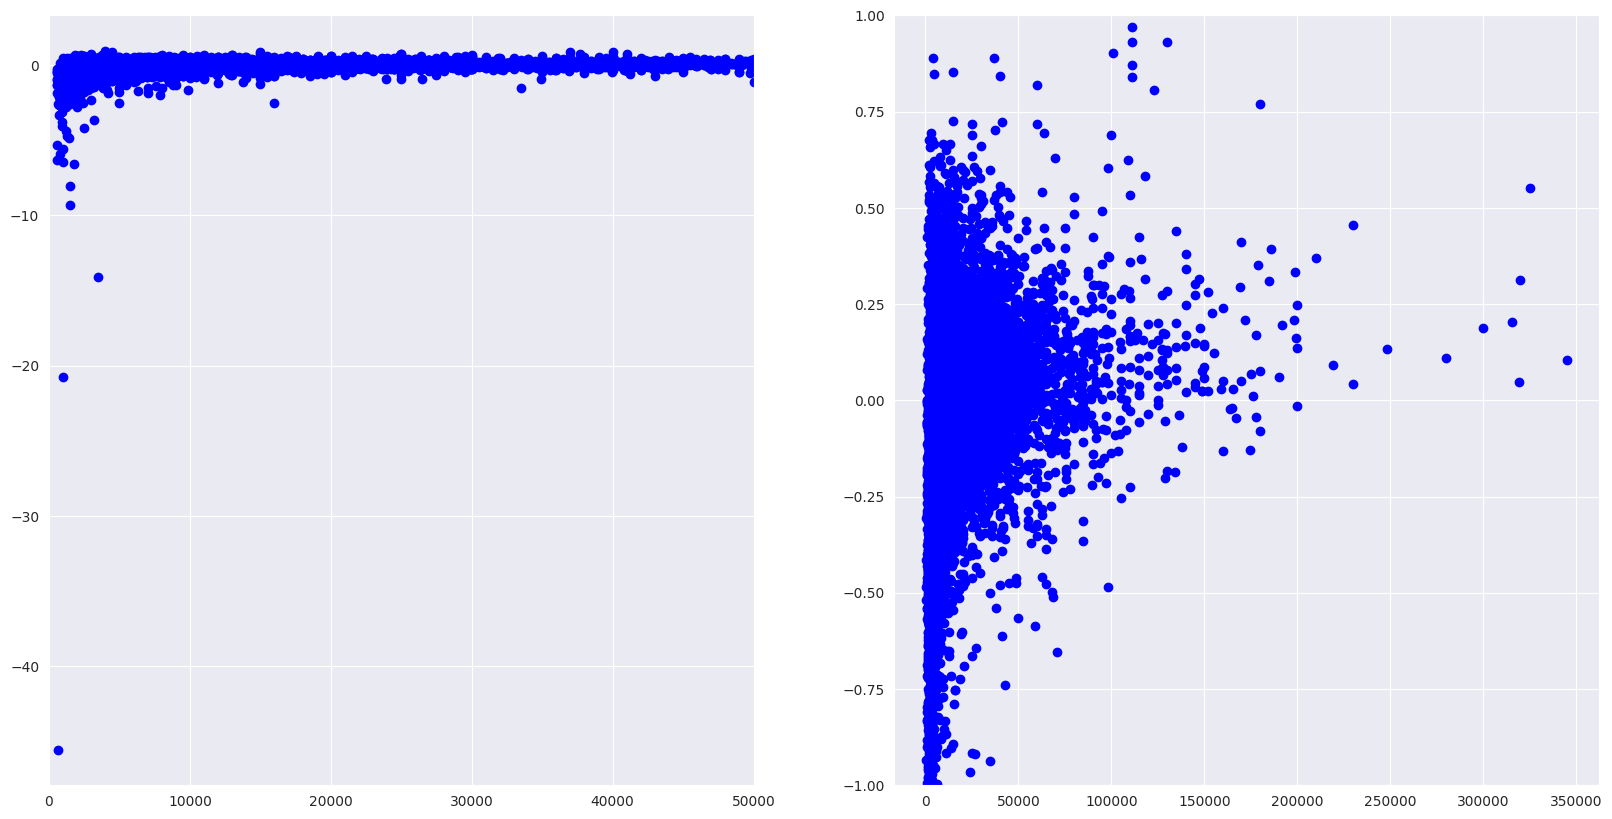

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax[0].scatter(res.raw_price, res.pe_all_extras, color='blue' )
ax[1].scatter(res.raw_price, res.pe_all_extras, color='blue' )
ax[0].set_xlim([0,50000])
ax[1].set_ylim([-1,1])

In [62]:
res[res.ape_all_extras> res.ape_all_extras.quantile(.99)].sort_values(by=['ape_all_extras'], ascending=False)

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,...,pred_outliers,pred_drop_all,pred_unpractical,pred_low_importance,pe_all_extras,pe_options,pe_outliers,pe_drop_all,pe_unpractical,pe_low_importance
3351,38.080682,23.814336,f1f8c60c-1837-49c7-993c-e97e41152f53,True,new,Peugeot 3008 '24 1.2 136hp Hybrid Allure LEASI...,"{'count': 3, 'urls': ['https://static.car.gr/4...",41403626,True,1010612,...,31921.869282,32450.302968,32610.811281,32107.226280,-45.583840,-43.087403,-47.002811,-47.797448,-48.038814,-47.281543
1385,38.092141,23.611706,44bae6a8-7501-4663-baf9-fd647fd18217,False,NaN,Mercedes-Benz Vito '15 LUXURY ΑΜΕΑ ΜΕ ΑΝΑΒΑΤΟΡΙΟ,"{'count': 16, 'urls': ['https://static.car.gr/...",30146936,True,1000061,...,20038.751162,22388.442510,20998.112288,21768.978799,-20.781552,-20.285729,-19.038751,-21.388443,-19.998112,-20.768979
79827,37.993972,23.721935,15dc3085-fe1a-48f9-8c0a-852479a33178,False,NaN,Mercedes-Benz Vito '21 MAYBACH,"{'count': 20, 'urls': ['https://static.car.gr/...",333522007,True,1009311,...,52294.259588,51243.720898,53230.016683,51910.615360,-14.086465,-13.919825,-13.941217,-13.641063,-14.208576,-13.831604
61041,37.840635,21.401010,2f0d6c97-23af-4e0b-95c4-b9100b65a9f4,False,NaN,Mercedes-Benz E 250 '01,"{'count': 5, 'urls': ['https://static.car.gr/4...",44158494,True,1001489042,...,15511.854108,15789.160439,12950.668953,13986.080325,-9.349020,-8.908003,-9.341236,-9.526107,-7.633779,-8.324054
73954,38.002706,23.728407,0d2cbafd-8b12-480a-97df-66d9fdfb5ae5,False,NaN,Chrysler New Yorker '01 LHS 1500€,"{'count': 13, 'urls': ['https://static.car.gr/...",316647828,True,4977999,...,11536.838970,14643.386916,13994.932050,12228.556498,-8.046509,-7.143604,-6.691226,-8.762258,-8.329955,-7.152371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,37.948849,23.643525,e73724cc-ce8d-4900-82ff-322f110ed454,False,NaN,Mercedes-Benz ML 320 '01,"{'count': 14, 'urls': ['https://static.car.gr/...",5299160,True,1005490,...,5209.858674,4967.725942,5082.601300,4926.166348,-0.972553,-0.857827,-1.083943,-0.987090,-1.033041,-0.970467
70579,39.484210,22.479922,ba8c8e1d-3506-449b-9a3e-af53e8c5a7c4,False,NaN,Mercedes-Benz A 200 '08,"{'count': 9, 'urls': ['https://static.car.gr/4...",44356365,True,1001521598,...,8300.768718,6421.005954,11019.417930,8174.593537,-0.971461,-1.013132,-1.371648,-0.834573,-2.148405,-1.335598
89394,37.828334,23.792839,75236d5e-a598-4a7b-a10d-a84f61764e72,False,NaN,Opel Astra '06,"{'count': 7, 'urls': ['https://static.car.gr/3...",340554859,True,1000668317,...,3298.415080,3316.647858,3385.523361,3302.769652,0.970443,0.970914,0.970314,0.970150,0.969530,0.970275
27820,37.970134,23.692959,cf788143-dbde-48ec-9130-8a65d042a46a,False,NaN,Renault Clio '18 90PS ΟΘΟΝΗ 35.000ΧΛΜ,"{'count': 6, 'urls': ['https://static.car.gr/4...",42639798,True,1002611,...,6916.320660,5522.429127,5716.032819,5697.843002,-0.970345,-1.123784,-1.384938,-0.904286,-0.971046,-0.964773


In [65]:
res.loc[(res.registration_year>2008)&(res.raw_price>2000)&(~res.crashed),'ape_all_extras'].describe(qs)

count    14792.000000
mean         0.100535
std          0.163397
min          0.000005
1%           0.001112
5%           0.005660
25%          0.031608
50%          0.071003
75%          0.131719
90%          0.212498
95%          0.281277
99%          0.484161
max         14.086465
Name: ape_all_extras, dtype: float64

In [68]:
pd.concat([res.loc[res.extra_turbo.isna(),'ape_all_extras'].describe(qs), res.loc[res.extra_turbo.notna(),'ape_all_extras'].describe(qs)],axis=1)

,ape_all_extras,ape_all_extras
count,3834.000000,16452.000000
mean,0.209708,0.132243
std,0.409845,0.443697
min,0.000023,0.000005
1%,0.001795,0.001221
5%,0.009877,0.006347
25%,0.055456,0.035426
50%,0.119877,0.081734
75%,0.234438,0.156289
90%,0.432801,0.272177


In [70]:
nan_cols = train.isna().sum()

In [71]:
nan_cols = nan_cols[nan_cols>0]

In [75]:
nan_cols.index.tolist()

['label',
 'thumbs',
 'battery_range',
 'variant',
 'description',
 'extra_turbo',
 'extra_steering_lights',
 'extra_collision_avoidance_system',
 'extra_trip_computer',
 'extra_wheelchair',
 'extra_apple_carplay',
 'extra_leather_seats',
 'extra_anti_theft_system_gps',
 'extra_rain_sensor',
 'extra_panoramic_roof',
 'extra_dvd',
 'extra_automatic_parking',
 'extra_multi_purpose_steering_wheel',
 'extra_tcs_asr',
 'extra_tv_camera',
 'extra_power_windows',
 'extra_bucket_seats',
 'extra_hitch',
 'extra_aircondition(a_c)',
 'extra_heated_seats',
 'extra_power_seats',
 'extra_alumium_rims',
 'extra_locking_differential',
 'extra_android_auto',
 'extra_roof_rails',
 'extra_armored',
 'extra_lane_assist',
 'never_crashed',
 'extra_immobilizer',
 'extra_rear_view_camera',
 'extra_air_suspension',
 'extra_bluetooth',
 'extra_parktronic',
 'extra_isofix_children_seats',
 'extra_electric_sunroof',
 'extra_abs',
 'extra_telephone',
 'extra_led_lights',
 'extra_gps',
 'extra_automatic_air_condit

In [76]:
test.dtypes

lat                                 float64
lon                                 float64
uuid                                 object
is_new                                 bool
label                                object
                                     ...   
safety_driver_assistance_options    float64
performance_handling_options        float64
utility_options                     float64
premium_options                     float64
infotainment_options                float64
Length: 119, dtype: object

In [6]:
def impute_object_col_on_group(group):
    if group.isna().sum() == group.shape[0]:
        return np.nan
    else:
        return group.mode()[0] if not group.mode().empty else np.nan

def impute_num_on_group(group):
    if group.isna().sum() == group.shape[0]:
        return np.nan
    else:
        return group.mean()[0] if not group.mean().empty else np.nan




In [40]:
def impute_missing_values(df, feature):
    #if object select majority among group, for groups only with nan go one level higher
    df = df.copy()

    if df.loc[df[feature].notna(),feature].dtype in ['object', 'bool','Int64', 'category']:
        print(df[feature].isna().sum())
        df[f'mode_{feature}'] = df.groupby(['brand','model','registration_year'])[feature].transform(impute_object_col_on_group)
        df.loc[df[feature].isna(),feature] = df.loc[df[feature].isna(),f'mode_{feature}'].drop(columns=[f'mode_{feature}'])
        print(df[feature].isna().sum())
        df[f'mode_{feature}'] = df.groupby(['brand','model'])[feature].transform(impute_object_col_on_group)
        df.loc[df[feature].isna(),feature] = df.loc[df[feature].isna(),f'mode_{feature}'].drop(columns=[f'mode_{feature}'])
        print(df[feature].isna().sum())
        df[f'mode_{feature}'] = df.groupby(['brand','model'])[feature].transform(impute_object_col_on_group)
        df.loc[df[feature].isna(),feature] = df.loc[df[feature].isna(),f'mode_{feature}'].drop(columns=[f'mode_{feature}'])
        print(df[feature].isna().sum())
        df.loc[df[feature].isna(),feature] = df[feature].mode()[0]
        print(df[feature].isna().sum())
    else:
        print(df[feature].isna().sum())
        df[f'mean_{feature}'] = df.groupby(['brand','model','registration_year'])[feature].transform(impute_num_on_group)
        df.loc[df[feature].isna(),feature] = df.loc[df[feature].isna(),f'mean_{feature}'].drop(columns=[f'mean_{feature}'])
        print(df[feature].isna().sum())
        df[f'mean_{feature}'] = df.groupby(['brand','model'])[feature].transform(impute_num_on_group)
        df.loc[df[feature].isna(),feature] = df.loc[df[feature].isna(),f'mean_{feature}'].drop(columns=[f'mean_{feature}'])
        print(df[feature].isna().sum())
        df[f'mean_{feature}'] = df.groupby(['brand','model'])[feature].transform(impute_num_on_group)
        df.loc[df[feature].isna(),feature] = df.loc[df[feature].isna(),f'mean_{feature}'].drop(columns=[f'mean_{feature}'])
        print(df[feature].isna().sum())
        df.loc[df[feature].isna(),feature] = df[feature].mean()[0]
        print(df[feature].isna().sum())

    return df

    #if float select mean among group

In [31]:
train.loc[train.extra_turbo.notna(),'duel'].dtype

dtype('O')

In [44]:
train.columns[train.isna().any()].tolist()

['label',
 'thumbs',
 'battery_range',
 'variant',
 'description',
 'extra_turbo',
 'extra_steering_lights',
 'extra_collision_avoidance_system',
 'extra_trip_computer',
 'extra_wheelchair',
 'extra_apple_carplay',
 'extra_leather_seats',
 'extra_anti_theft_system_gps',
 'extra_rain_sensor',
 'extra_panoramic_roof',
 'extra_dvd',
 'extra_automatic_parking',
 'extra_multi_purpose_steering_wheel',
 'extra_tcs_asr',
 'extra_tv_camera',
 'extra_power_windows',
 'extra_bucket_seats',
 'extra_hitch',
 'extra_aircondition(a_c)',
 'extra_heated_seats',
 'extra_power_seats',
 'extra_alumium_rims',
 'extra_locking_differential',
 'extra_android_auto',
 'extra_roof_rails',
 'extra_armored',
 'extra_lane_assist',
 'never_crashed',
 'extra_immobilizer',
 'extra_rear_view_camera',
 'extra_air_suspension',
 'extra_bluetooth',
 'extra_parktronic',
 'extra_isofix_children_seats',
 'extra_electric_sunroof',
 'extra_abs',
 'extra_telephone',
 'extra_led_lights',
 'extra_gps',
 'extra_automatic_air_condit

In [192]:
train, test = load_train_test()


In [41]:
zoom = impute_missing_values(train, 'interior_type')

28588
1128
91
91
0


In [ ]:
load_model()

In [85]:
zoomzoom = impute_missing_values(test,'extra_turbo',group_col)

UnboundLocalError: local variable 'zoom' referenced before assignment

In [52]:
import pandas as pd

In [53]:
zoom = pd.read_csv('data/car_ads.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/car_ads.csv'

In [ ]:
zoo